In [1]:
import sys
import os

# Add the project directory to the Python path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
!pip install pandas openpyxl
!pip install statsmodels
!pip install arch
!pip install tensorflow
!pip install boto3
!pip install requests
!pip install numpy
!pip install joblib matplotlib
!pip install prophet
!pip install tabulate

In [3]:
import pandas as pd
import numpy as np
import boto3
import joblib
import tarfile
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scripts.preprocessing import load_data_csv, make_stationary, split_data, save_model_local, upload_model_s3, calculate_metrics
from prophet import Prophet
from scipy import stats
import seaborn as sns
from tabulate import tabulate

In [4]:
bucket = 'bk-price-prediction-data'
file_key = 'data/JAMON/JAMON_DATASET_1.csv'
separator = ','
df = load_data_csv(bucket, file_key, separator)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    191 non-null    object 
 1   PRICE   191 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB


In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

In [6]:
# Remove outliers from the DataFrame
df = df[(np.abs(stats.zscore(df['PRICE'])) < 3)]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2021-01-04 to 2024-07-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   187 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [7]:
# Normalize data
scaler = MinMaxScaler()
df['PRICE'] = scaler.fit_transform(df[['PRICE']])

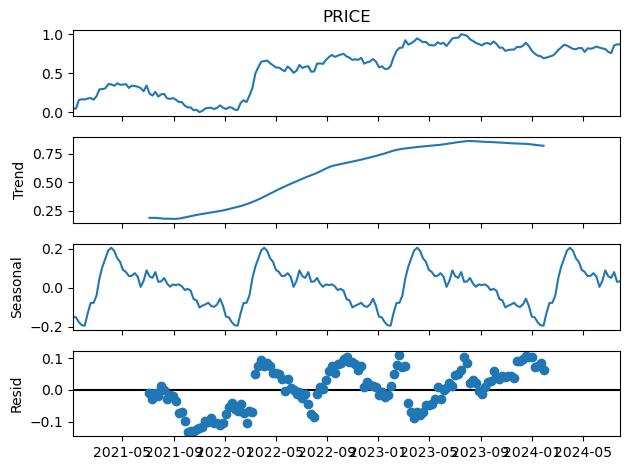

In [8]:
decomposition = seasonal_decompose(df['PRICE'], model='additive', period=52)

# Plot the decomposition
decomposition.plot()
plt.show()

In [9]:
# Prepare data for Prophet
df_prophet = df.reset_index().rename(columns={'DATE': 'ds', 'PRICE': 'y'})

In [10]:
train, test = split_data(df_prophet)

In [11]:
# Initialize and fit Prophet model
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.1,  # Adjust this parameter
    seasonality_prior_scale=10.0  # Adjust this parameter
)
model.fit(train)

20:34:10 - cmdstanpy - INFO - Chain [1] start processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Make predictions
forecast = model.predict(test)

In [13]:
# Evaluate the model
predictions = forecast['yhat'][-len(test):].values
true_values = test['y'].values

In [14]:
results=calculate_metrics(true_values,predictions)

In [15]:
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

+----------+------------+
| Metric   |      Value |
+==========+============+
| MAE      |  0.303869  |
+----------+------------+
| MSE      |  0.0977706 |
+----------+------------+
| RMSE     |  0.312683  |
+----------+------------+
| MAPE     | 38.2787    |
+----------+------------+


In [16]:
name_model = 'model_jamon'
save_model_local(model,name_model)

Created ../model/model_jamon.tar.gz containing ../model/model_jamon.joblib


In [17]:
# Upload the model to S3
upload_model_s3(name_model, bucket)

upload s3
